In [ ]:
!pip install -U transformers==4.46.2 accelerate==1.2.1 datasets evaluate seqeval sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 106.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 121.1 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=3cb17d20ea3b08468d1b17a6bf2f07997b1a39a910d7d84c28ee6e80da0eeed0
  Stored in directory: /root/.cache/pip/wheels/5f/b8/73/0b2c1a76b701a677653dd79ece07cfabd7457989dbfbdcd8d7
Successfully built seqeval
  Attempting uninstall: pyarrow
    

In [ ]:
!pip uninstall -y peft

Found existing installation: peft 0.18.0
Uninstalling peft-0.18.0:
  Successfully uninstalled peft-0.18.0


In [ ]:

import pandas as pd
import numpy as np
import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    DataCollatorForTokenClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
import evaluate
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from collections import Counter

# ---------------- CONFIG ----------------
MODEL_NAME = "xlm-roberta-base"   # Fixed: use full model name
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 5 # Increased
LEARNING_RATE = 2e-5  # Lowered for better convergence
WEIGHT_DECAY = 0.01
GRADIENT_ACCUMULATION = 2
WARMUP_STEPS = 500
FP16 = True

# ---------------- LOAD CSV ----------------
try:
    df = pd.read_csv("/content/TV_Reviews(Sheet1).csv")
    assert {"sentence_id", "word", "tag"}.issubset(df.columns), "CSV must have sentence_id, word, tag"
    print(f"✅ Loaded CSV: {len(df)} rows")
except Exception as e:
    print(f"❌ Error loading CSV: {e}")
    raise

# ---------------- GROUP SENTENCES ----------------
sentences = []
tags = []
for _, g in df.groupby("sentence_id"):
    words = g["word"].tolist()
    tag_list = g["tag"].tolist()
    if len(words) > 0 and len(words) == len(tag_list):  # Basic validation
        sentences.append(words)
        tags.append(tag_list)

print(f"✅ Total sentences: {len(sentences)}")

# ---------------- LABELS ----------------
label_list = sorted(list({t for seq in tags for t in seq}))
if len(label_list) != 3:
    print(f"⚠️ Warning: found {len(label_list)} unique labels in data. Expected 3.")
label2id = {l: i for i, l in enumerate(label_list)}
id2label = {i: l for l, i in label2id.items()}
num_labels = len(label_list)
print("Labels:", label_list)

# Calculate class weights
all_tags = [t for seq in tags for t in seq]
tag_counts = Counter(all_tags)
total = len(all_tags)
class_weights = torch.tensor([
    total / (num_labels * tag_counts[id2label[i]])
    for i in range(num_labels)
], dtype=torch.float32)
print(f"Class weights: {class_weights.tolist()}")

# Convert tags -> ids
label_ids = [[label2id[t] for t in seq] for seq in tags]

# ---------------- HF DATASET ----------------
hf_ds = Dataset.from_dict({"tokens": sentences, "labels": label_ids})

# ---------------- TOKENIZER ----------------
try:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
    print(f"✅ Loaded tokenizer: {MODEL_NAME}")
except Exception as e:
    print(f"❌ Error loading tokenizer: {e}")
    raise

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        is_split_into_words=True,
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN,
    )
    aligned_labels = []
    for i, lab in enumerate(examples["labels"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        prev_word_idx = None
        label_ids_per_token = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids_per_token.append(-100)
            elif word_idx != prev_word_idx:
                label_ids_per_token.append(lab[word_idx])
            else:
                label_ids_per_token.append(-100)
            prev_word_idx = word_idx
        aligned_labels.append(label_ids_per_token)
    tokenized_inputs["labels"] = aligned_labels
    return tokenized_inputs

# ---------------- METRICS HELPERS ----------------
seqeval = evaluate.load("seqeval")

def compute_metrics(p):
    preds, labels = p
    preds = np.argmax(preds, axis=2)

    true_preds = [
        [label_list[p] for (p, l) in zip(pred_seq, lab_seq) if l != -100]
        for pred_seq, lab_seq in zip(preds, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(pred_seq, lab_seq) if l != -100]
        for pred_seq, lab_seq in zip(preds, labels)
    ]

    results = seqeval.compute(predictions=true_preds, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

# ---------------- K-FOLD SPLITS ----------------
kf = KFold(n_splits=6, shuffle=True, random_state=42)
splits = list(kf.split(hf_ds))

print(f"✅ Prepared {len(splits)} folds (shuffle=True, random_state=42).")

✅ Loaded CSV: 156936 rows
✅ Total sentences: 12044
Labels: ['BOC', 'IOC', 'O']
Class weights: [4.932302474975586, 1.3662053346633911, 0.48419103026390076]
✅ Loaded tokenizer: xlm-roberta-base
✅ Prepared 6 folds (shuffle=True, random_state=42).


Map:   0%|          | 0/10036 [00:00<?, ? examples/s]

Map:   0%|          | 0/2008 [00:00<?, ? examples/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipython-input-258494361.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🚀 Training Fold 1 (epochs=5) ...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.751200,0.569198,0.213861,0.206304,0.210015,0.767233
2,0.553800,0.500409,0.337113,0.312321,0.324244,0.797181
3,0.485100,0.464388,0.371725,0.359121,0.365315,0.813457
4,0.434600,0.457303,0.403518,0.372493,0.387385,0.821347
5,0.403100,0.460345,0.394966,0.389685,0.392308,0.821538


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: BOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: IOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))



📊 Trainer Evaluate (Fold 1)



--- TRAIN METRICS (from trainer.evaluate) ---
{'eval_loss': 0.35378438234329224, 'eval_precision': 0.4427165354330709, 'eval_recall': 0.43034825870646765, 'eval_f1': 0.4364447894430429, 'eval_accuracy': 0.858924967895799, 'eval_runtime': 22.6624, 'eval_samples_per_second': 442.849, 'eval_steps_per_second': 27.711, 'epoch': 5.0}

--- TEST METRICS (from trainer.evaluate) ---
{'eval_loss': 0.4603453576564789, 'eval_precision': 0.39496611810261373, 'eval_recall': 0.38968481375358166, 'eval_f1': 0.3923076923076923, 'eval_accuracy': 0.8215379901960784, 'eval_runtime': 4.2513, 'eval_samples_per_second': 472.323, 'eval_steps_per_second': 29.638, 'epoch': 5.0}

Train classification report:
              precision    recall  f1-score   support

         BOC       0.69      0.56      0.62      8829
         IOC       0.78      0.75      0.77     31973
           O       0.90      0.93      0.91     90022

    accuracy                           0.86    130824
   macro avg       0.79      0.75    

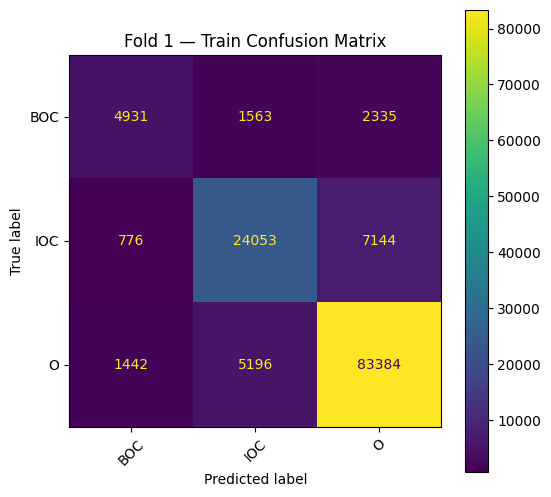

/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: BOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: IOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))



Test classification report:
              precision    recall  f1-score   support

         BOC       0.63      0.50      0.56      1777
         IOC       0.71      0.69      0.70      6317
           O       0.87      0.90      0.89     18018

    accuracy                           0.82     26112
   macro avg       0.74      0.70      0.72     26112
weighted avg       0.82      0.82      0.82     26112



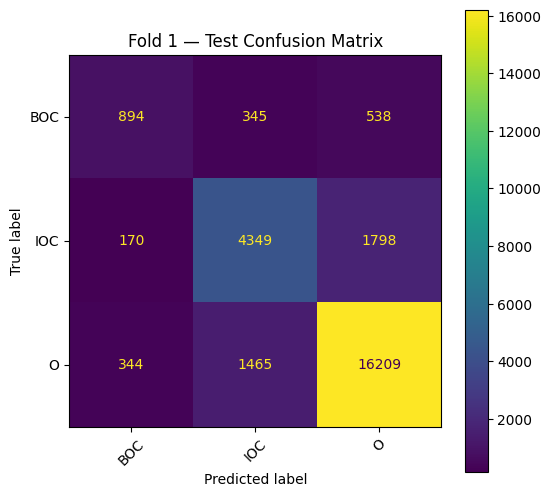

In [ ]:
# CELL 1 — FOLD 1
fold_idx = 1
train_idx, test_idx = splits[0]

train_data = hf_ds.select(train_idx)
test_data  = hf_ds.select(test_idx)

tokenized_train = train_data.map(tokenize_and_align_labels, batched=True, remove_columns=train_data.column_names)
tokenized_test  = test_data.map(tokenize_and_align_labels, batched=True, remove_columns=test_data.column_names)

# create model and move to GPU
model = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

training_args = TrainingArguments(
    output_dir=f"./fold{fold_idx}",
    evaluation_strategy="epoch",
    save_strategy="no",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION,
    learning_rate=LEARNING_RATE,
    num_train_epochs=EPOCHS,
    weight_decay=WEIGHT_DECAY,
    warmup_steps=WARMUP_STEPS,
    fp16=FP16 and torch.cuda.is_available(),
    logging_strategy="epoch",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    compute_metrics=compute_metrics
)

print(f"🚀 Training Fold {fold_idx} (epochs={EPOCHS}) ...")
trainer.train()

# Evaluate (trainer.evaluate uses compute_metrics)
print(f"\n📊 Trainer Evaluate (Fold {fold_idx})")
eval_metrics = trainer.evaluate(eval_dataset=tokenized_test)
train_metrics = trainer.evaluate(eval_dataset=tokenized_train)

print("\n--- TRAIN METRICS (from trainer.evaluate) ---")
print(train_metrics)
print("\n--- TEST METRICS (from trainer.evaluate) ---")
print(eval_metrics)

# ---------------- Predictions & Confusion Matrices ----------------
def preds_and_labels(tok_dataset):
    preds_output = trainer.predict(tok_dataset)
    preds = np.argmax(preds_output.predictions, axis=2)
    labels = preds_output.label_ids

    y_true = []
    y_pred = []
    for pred_seq, label_seq in zip(preds, labels):
        for p, l in zip(pred_seq, label_seq):
            if l != -100:
                y_true.append(id2label[int(l)])
                y_pred.append(id2label[int(p)])
    return y_true, y_pred

# Train confusion matrix
y_true_train, y_pred_train = preds_and_labels(tokenized_train)
cm_labels = label_list  # sorted label strings
cm_train = confusion_matrix(y_true_train, y_pred_train, labels=cm_labels, normalize=None)
print("\nTrain classification report:")
print(classification_report(y_true_train, y_pred_train, labels=cm_labels, zero_division=0))
fig = plt.figure(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=cm_labels)
disp.plot(ax=plt.gca(), xticks_rotation=45)
plt.title(f"Fold {fold_idx} — Train Confusion Matrix")
plt.show()

# Test confusion matrix
y_true_test, y_pred_test = preds_and_labels(tokenized_test)
cm_test = confusion_matrix(y_true_test, y_pred_test, labels=cm_labels, normalize=None)
print("\nTest classification report:")
print(classification_report(y_true_test, y_pred_test, labels=cm_labels, zero_division=0))
fig = plt.figure(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=cm_labels)
disp.plot(ax=plt.gca(), xticks_rotation=45)
plt.title(f"Fold {fold_idx} — Test Confusion Matrix")
plt.show()


Map:   0%|          | 0/10036 [00:00<?, ? examples/s]

Map:   0%|          | 0/2008 [00:00<?, ? examples/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipython-input-3962749016.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🚀 Training Fold 2 (epochs=5) ...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.757100,0.582362,0.235888,0.246759,0.241201,0.761791
2,0.560400,0.514786,0.336570,0.299568,0.316993,0.792019
3,0.491300,0.474140,0.348566,0.344215,0.346377,0.804079
4,0.444100,0.465196,0.377008,0.360538,0.368589,0.812375
5,0.410700,0.466689,0.366667,0.359097,0.362843,0.814488


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: IOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: BOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))



📊 Trainer Evaluate (Fold 2)



--- TRAIN METRICS (from trainer.evaluate) ---
{'eval_loss': 0.3627253472805023, 'eval_precision': 0.4404973357015986, 'eval_recall': 0.42664627735831023, 'eval_f1': 0.4334611836675244, 'eval_accuracy': 0.8559129106187929, 'eval_runtime': 22.3207, 'eval_samples_per_second': 449.627, 'eval_steps_per_second': 28.135, 'epoch': 5.0}

--- TEST METRICS (from trainer.evaluate) ---
{'eval_loss': 0.4666885435581207, 'eval_precision': 0.36666666666666664, 'eval_recall': 0.35909745559289485, 'eval_f1': 0.36284259034683486, 'eval_accuracy': 0.8144876325088339, 'eval_runtime': 4.2248, 'eval_samples_per_second': 475.291, 'eval_steps_per_second': 29.824, 'epoch': 5.0}

Train classification report:
              precision    recall  f1-score   support

         BOC       0.68      0.56      0.61      8856
         IOC       0.77      0.75      0.76     32004
           O       0.90      0.92      0.91     90040

    accuracy                           0.86    130900
   macro avg       0.78      0.74   

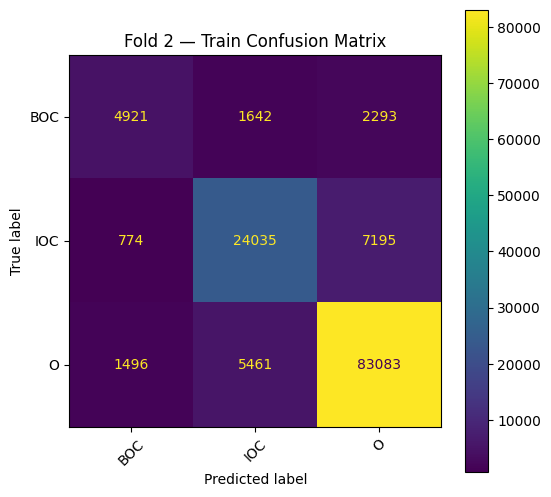

/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: IOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: BOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))



Test classification report:
              precision    recall  f1-score   support

         BOC       0.61      0.49      0.55      1750
         IOC       0.70      0.67      0.68      6286
           O       0.87      0.90      0.88     18000

    accuracy                           0.81     26036
   macro avg       0.73      0.69      0.70     26036
weighted avg       0.81      0.81      0.81     26036



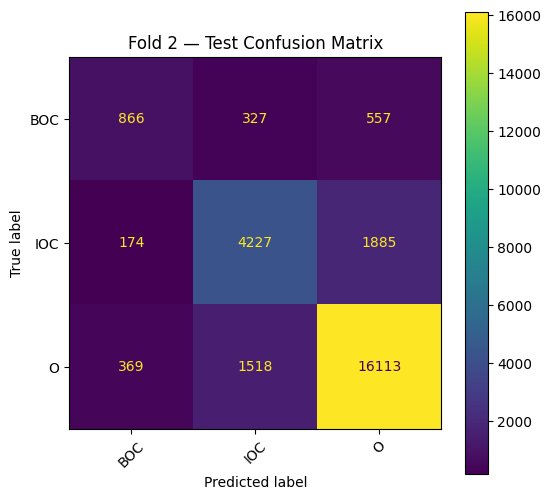

In [ ]:
# CELL 2 — FOLD 2
fold_idx = 2
train_idx, test_idx = splits[1]

train_data = hf_ds.select(train_idx)
test_data  = hf_ds.select(test_idx)

tokenized_train = train_data.map(tokenize_and_align_labels, batched=True, remove_columns=train_data.column_names)
tokenized_test  = test_data.map(tokenize_and_align_labels, batched=True, remove_columns=test_data.column_names)

model = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

training_args = TrainingArguments(
    output_dir=f"./fold{fold_idx}",
    evaluation_strategy="epoch",
    save_strategy="no",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION,
    learning_rate=LEARNING_RATE,
    num_train_epochs=EPOCHS,
    weight_decay=WEIGHT_DECAY,
    warmup_steps=WARMUP_STEPS,
    fp16=FP16 and torch.cuda.is_available(),
    logging_strategy="epoch",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    compute_metrics=compute_metrics
)

print(f"🚀 Training Fold {fold_idx} (epochs={EPOCHS}) ...")
trainer.train()

print(f"\n📊 Trainer Evaluate (Fold {fold_idx})")
eval_metrics = trainer.evaluate(eval_dataset=tokenized_test)
train_metrics = trainer.evaluate(eval_dataset=tokenized_train)

print("\n--- TRAIN METRICS (from trainer.evaluate) ---")
print(train_metrics)
print("\n--- TEST METRICS (from trainer.evaluate) ---")
print(eval_metrics)

# Confusion matrices
def preds_and_labels(tok_dataset):
    preds_output = trainer.predict(tok_dataset)
    preds = np.argmax(preds_output.predictions, axis=2)
    labels = preds_output.label_ids

    y_true = []
    y_pred = []
    for pred_seq, label_seq in zip(preds, labels):
        for p, l in zip(pred_seq, label_seq):
            if l != -100:
                y_true.append(id2label[int(l)])
                y_pred.append(id2label[int(p)])
    return y_true, y_pred

y_true_train, y_pred_train = preds_and_labels(tokenized_train)
cm_labels = label_list
print("\nTrain classification report:")
print(classification_report(y_true_train, y_pred_train, labels=cm_labels, zero_division=0))
fig = plt.figure(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true_train, y_pred_train, labels=cm_labels), display_labels=cm_labels)
disp.plot(ax=plt.gca(), xticks_rotation=45)
plt.title(f"Fold {fold_idx} — Train Confusion Matrix")
plt.show()

y_true_test, y_pred_test = preds_and_labels(tokenized_test)
print("\nTest classification report:")
print(classification_report(y_true_test, y_pred_test, labels=cm_labels, zero_division=0))
fig = plt.figure(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true_test, y_pred_test, labels=cm_labels), display_labels=cm_labels)
disp.plot(ax=plt.gca(), xticks_rotation=45)
plt.title(f"Fold {fold_idx} — Test Confusion Matrix")
plt.show()


Map:   0%|          | 0/10037 [00:00<?, ? examples/s]

Map:   0%|          | 0/2007 [00:00<?, ? examples/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipython-input-4291839201.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🚀 Training Fold 3 (epochs=5) ...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.760500,0.588693,0.210526,0.241560,0.224978,0.755902
2,0.559900,0.501655,0.320020,0.297194,0.308185,0.798465
3,0.487300,0.484090,0.350588,0.354256,0.352412,0.804628
4,0.442700,0.470644,0.375126,0.352829,0.363636,0.813971
5,0.412300,0.472493,0.368845,0.370423,0.369632,0.813505


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: IOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: BOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))



📊 Trainer Evaluate (Fold 3)



--- TRAIN METRICS (from trainer.evaluate) ---
{'eval_loss': 0.36352425813674927, 'eval_precision': 0.42866769349249134, 'eval_recall': 0.4264100354304319, 'eval_f1': 0.42753588401901016, 'eval_accuracy': 0.8546961620875559, 'eval_runtime': 22.4645, 'eval_samples_per_second': 446.794, 'eval_steps_per_second': 27.955, 'epoch': 5.0}

--- TEST METRICS (from trainer.evaluate) ---
{'eval_loss': 0.4724928140640259, 'eval_precision': 0.36884469696969696, 'eval_recall': 0.3704232049453162, 'eval_f1': 0.3696322657176749, 'eval_accuracy': 0.8135054463697329, 'eval_runtime': 4.3821, 'eval_samples_per_second': 457.998, 'eval_steps_per_second': 28.753, 'epoch': 5.0}

Train classification report:
              precision    recall  f1-score   support

         BOC       0.68      0.56      0.61      8822
         IOC       0.77      0.75      0.76     31962
           O       0.90      0.92      0.91     90355

    accuracy                           0.85    131139
   macro avg       0.78      0.74   

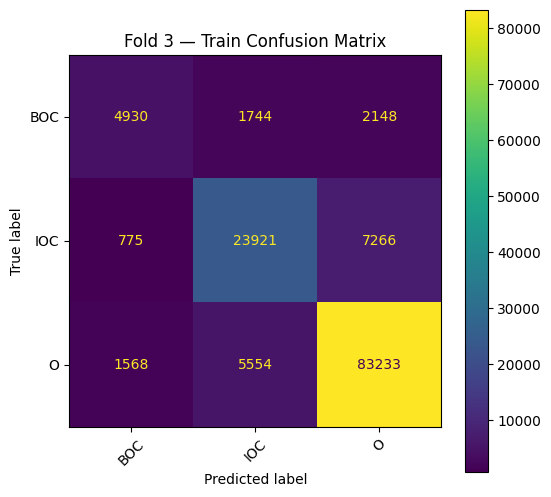

/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: IOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: BOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))



Test classification report:
              precision    recall  f1-score   support

         BOC       0.61      0.50      0.55      1784
         IOC       0.69      0.68      0.69      6328
           O       0.87      0.89      0.88     17685

    accuracy                           0.81     25797
   macro avg       0.73      0.69      0.71     25797
weighted avg       0.81      0.81      0.81     25797



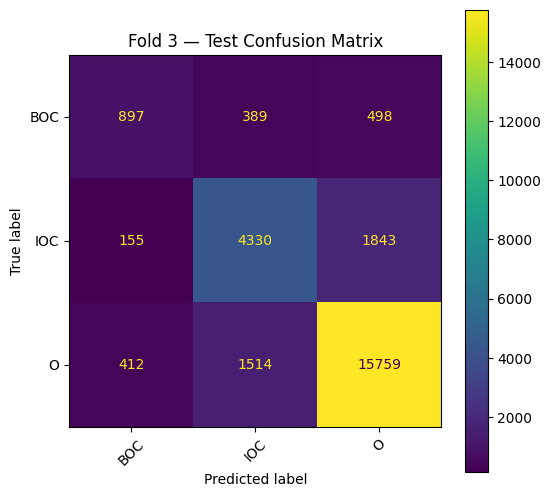

In [ ]:
# CELL 3 — FOLD 3
fold_idx = 3
train_idx, test_idx = splits[2]

train_data = hf_ds.select(train_idx)
test_data  = hf_ds.select(test_idx)

tokenized_train = train_data.map(tokenize_and_align_labels, batched=True, remove_columns=train_data.column_names)
tokenized_test  = test_data.map(tokenize_and_align_labels, batched=True, remove_columns=test_data.column_names)

model = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

training_args = TrainingArguments(
    output_dir=f"./fold{fold_idx}",
    evaluation_strategy="epoch",
    save_strategy="no",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION,
    learning_rate=LEARNING_RATE,
    num_train_epochs=EPOCHS,
    weight_decay=WEIGHT_DECAY,
    warmup_steps=WARMUP_STEPS,
    fp16=FP16 and torch.cuda.is_available(),
    logging_strategy="epoch",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    compute_metrics=compute_metrics
)

print(f"🚀 Training Fold {fold_idx} (epochs={EPOCHS}) ...")
trainer.train()

print(f"\n📊 Trainer Evaluate (Fold {fold_idx})")
eval_metrics = trainer.evaluate(eval_dataset=tokenized_test)
train_metrics = trainer.evaluate(eval_dataset=tokenized_train)

print("\n--- TRAIN METRICS (from trainer.evaluate) ---")
print(train_metrics)
print("\n--- TEST METRICS (from trainer.evaluate) ---")
print(eval_metrics)

# Confusion matrices same as above
def preds_and_labels(tok_dataset):
    preds_output = trainer.predict(tok_dataset)
    preds = np.argmax(preds_output.predictions, axis=2)
    labels = preds_output.label_ids

    y_true = []
    y_pred = []
    for pred_seq, label_seq in zip(preds, labels):
        for p, l in zip(pred_seq, label_seq):
            if l != -100:
                y_true.append(id2label[int(l)])
                y_pred.append(id2label[int(p)])
    return y_true, y_pred

y_true_train, y_pred_train = preds_and_labels(tokenized_train)
cm_labels = label_list
print("\nTrain classification report:")
print(classification_report(y_true_train, y_pred_train, labels=cm_labels, zero_division=0))
fig = plt.figure(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true_train, y_pred_train, labels=cm_labels), display_labels=cm_labels)
disp.plot(ax=plt.gca(), xticks_rotation=45)
plt.title(f"Fold {fold_idx} — Train Confusion Matrix")
plt.show()

y_true_test, y_pred_test = preds_and_labels(tokenized_test)
print("\nTest classification report:")
print(classification_report(y_true_test, y_pred_test, labels=cm_labels, zero_division=0))
fig = plt.figure(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true_test, y_pred_test, labels=cm_labels), display_labels=cm_labels)
disp.plot(ax=plt.gca(), xticks_rotation=45)
plt.title(f"Fold {fold_idx} — Test Confusion Matrix")
plt.show()


Map:   0%|          | 0/10037 [00:00<?, ? examples/s]

Map:   0%|          | 0/2007 [00:00<?, ? examples/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipython-input-2070851630.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🚀 Training Fold 4 (epochs=5) ...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.760300,0.579541,0.216309,0.212776,0.214528,0.759073
2,0.555900,0.511631,0.318919,0.311720,0.315278,0.792467
3,0.486300,0.469545,0.349487,0.360231,0.354778,0.808707
4,0.438000,0.465560,0.360399,0.364553,0.362464,0.812595
5,0.408700,0.461357,0.368523,0.365514,0.367012,0.817627


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: BOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: IOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))



📊 Trainer Evaluate (Fold 4)



--- TRAIN METRICS (from trainer.evaluate) ---
{'eval_loss': 0.35740599036216736, 'eval_precision': 0.437047057686733, 'eval_recall': 0.4322438837920489, 'eval_f1': 0.4346322010282035, 'eval_accuracy': 0.8564083731178846, 'eval_runtime': 22.1802, 'eval_samples_per_second': 452.52, 'eval_steps_per_second': 28.314, 'epoch': 5.0}

--- TEST METRICS (from trainer.evaluate) ---
{'eval_loss': 0.461357057094574, 'eval_precision': 0.36852300242130753, 'eval_recall': 0.3655139289145053, 'eval_f1': 0.36701229804678087, 'eval_accuracy': 0.8176273254040866, 'eval_runtime': 4.2062, 'eval_samples_per_second': 477.154, 'eval_steps_per_second': 29.956, 'epoch': 5.0}

Train classification report:
              precision    recall  f1-score   support

         BOC       0.69      0.56      0.62      8843
         IOC       0.77      0.75      0.76     31882
           O       0.90      0.92      0.91     89979

    accuracy                           0.86    130704
   macro avg       0.79      0.75      0

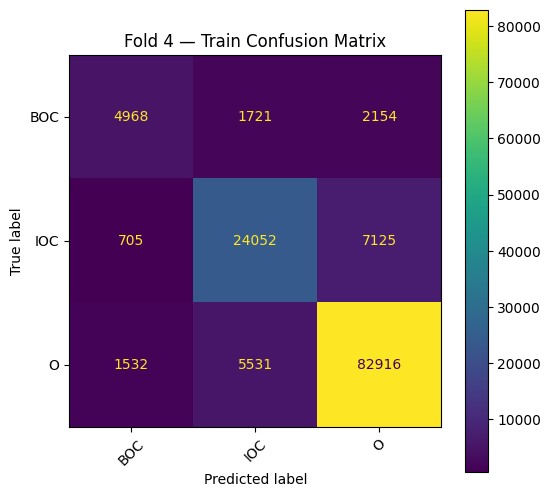

/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: BOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: IOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))



Test classification report:
              precision    recall  f1-score   support

         BOC       0.62      0.49      0.55      1763
         IOC       0.70      0.69      0.69      6408
           O       0.87      0.90      0.88     18061

    accuracy                           0.82     26232
   macro avg       0.73      0.69      0.71     26232
weighted avg       0.81      0.82      0.81     26232



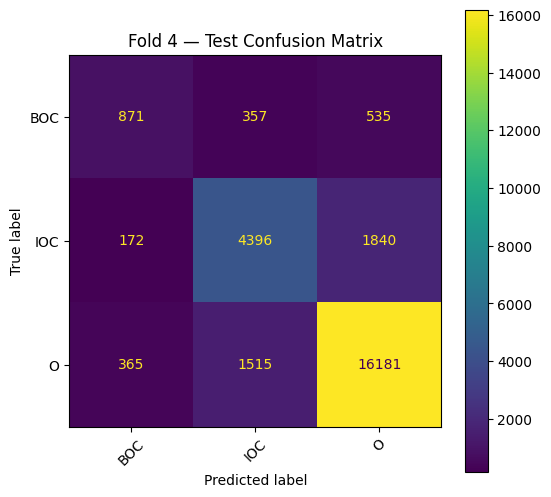

In [ ]:
# CELL 4 — FOLD 4
fold_idx = 4
train_idx, test_idx = splits[3]

train_data = hf_ds.select(train_idx)
test_data  = hf_ds.select(test_idx)

tokenized_train = train_data.map(tokenize_and_align_labels, batched=True, remove_columns=train_data.column_names)
tokenized_test  = test_data.map(tokenize_and_align_labels, batched=True, remove_columns=test_data.column_names)

model = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

training_args = TrainingArguments(
    output_dir=f"./fold{fold_idx}",
    evaluation_strategy="epoch",
    save_strategy="no",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION,
    learning_rate=LEARNING_RATE,
    num_train_epochs=EPOCHS,
    weight_decay=WEIGHT_DECAY,
    warmup_steps=WARMUP_STEPS,
    fp16=FP16 and torch.cuda.is_available(),
    logging_strategy="epoch",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    compute_metrics=compute_metrics
)

print(f"🚀 Training Fold {fold_idx} (epochs={EPOCHS}) ...")
trainer.train()

print(f"\n📊 Trainer Evaluate (Fold {fold_idx})")
eval_metrics = trainer.evaluate(eval_dataset=tokenized_test)
train_metrics = trainer.evaluate(eval_dataset=tokenized_train)

print("\n--- TRAIN METRICS (from trainer.evaluate) ---")
print(train_metrics)
print("\n--- TEST METRICS (from trainer.evaluate) ---")
print(eval_metrics)

# Confusion matrices
def preds_and_labels(tok_dataset):
    preds_output = trainer.predict(tok_dataset)
    preds = np.argmax(preds_output.predictions, axis=2)
    labels = preds_output.label_ids

    y_true = []
    y_pred = []
    for pred_seq, label_seq in zip(preds, labels):
        for p, l in zip(pred_seq, label_seq):
            if l != -100:
                y_true.append(id2label[int(l)])
                y_pred.append(id2label[int(p)])
    return y_true, y_pred

y_true_train, y_pred_train = preds_and_labels(tokenized_train)
cm_labels = label_list
print("\nTrain classification report:")
print(classification_report(y_true_train, y_pred_train, labels=cm_labels, zero_division=0))
fig = plt.figure(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true_train, y_pred_train, labels=cm_labels), display_labels=cm_labels)
disp.plot(ax=plt.gca(), xticks_rotation=45)
plt.title(f"Fold {fold_idx} — Train Confusion Matrix")
plt.show()

y_true_test, y_pred_test = preds_and_labels(tokenized_test)
print("\nTest classification report:")
print(classification_report(y_true_test, y_pred_test, labels=cm_labels, zero_division=0))
fig = plt.figure(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true_test, y_pred_test, labels=cm_labels), display_labels=cm_labels)
disp.plot(ax=plt.gca(), xticks_rotation=45)
plt.title(f"Fold {fold_idx} — Test Confusion Matrix")
plt.show()


Map:   0%|          | 0/10037 [00:00<?, ? examples/s]

Map:   0%|          | 0/2007 [00:00<?, ? examples/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipython-input-2644665740.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🚀 Training Fold 5 (epochs=5) ...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.762500,0.596225,0.186511,0.214252,0.199421,0.753148
2,0.555900,0.507522,0.318053,0.321856,0.319943,0.793776
3,0.486200,0.473425,0.356931,0.344811,0.350766,0.812683
4,0.435900,0.465594,0.358048,0.364897,0.361440,0.814243
5,0.407700,0.467049,0.365747,0.361549,0.363636,0.817058


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: BOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: IOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))



📊 Trainer Evaluate (Fold 5)



--- TRAIN METRICS (from trainer.evaluate) ---
{'eval_loss': 0.3557453751564026, 'eval_precision': 0.4328970502051182, 'eval_recall': 0.4239120038259206, 'eval_f1': 0.4283574155511526, 'eval_accuracy': 0.8568913654142014, 'eval_runtime': 22.3756, 'eval_samples_per_second': 448.569, 'eval_steps_per_second': 28.066, 'epoch': 5.0}

--- TEST METRICS (from trainer.evaluate) ---
{'eval_loss': 0.4670487940311432, 'eval_precision': 0.36574746008708275, 'eval_recall': 0.3615494978479197, 'eval_f1': 0.3636363636363637, 'eval_accuracy': 0.8170578613002625, 'eval_runtime': 4.226, 'eval_samples_per_second': 474.913, 'eval_steps_per_second': 29.815, 'epoch': 5.0}

Train classification report:
              precision    recall  f1-score   support

         BOC       0.70      0.55      0.62      8833
         IOC       0.78      0.74      0.76     31826
           O       0.89      0.93      0.91     89990

    accuracy                           0.86    130649
   macro avg       0.79      0.74      0

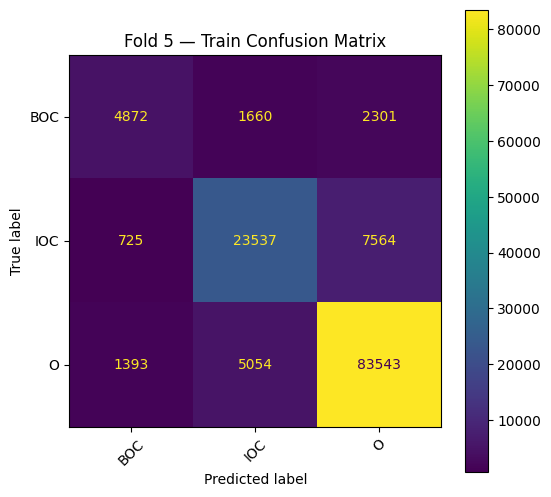

/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: BOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: IOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))



Test classification report:
              precision    recall  f1-score   support

         BOC       0.62      0.48      0.54      1773
         IOC       0.71      0.66      0.69      6464
           O       0.86      0.91      0.88     18050

    accuracy                           0.82     26287
   macro avg       0.73      0.68      0.70     26287
weighted avg       0.81      0.82      0.81     26287



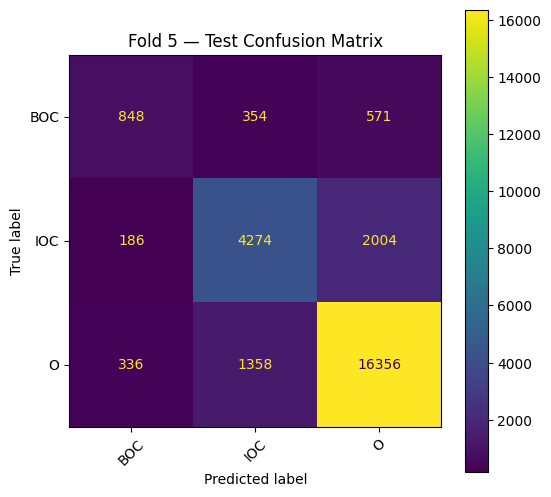

In [ ]:
# CELL 5 — FOLD 5
fold_idx = 5
train_idx, test_idx = splits[4]

train_data = hf_ds.select(train_idx)
test_data  = hf_ds.select(test_idx)

tokenized_train = train_data.map(tokenize_and_align_labels, batched=True, remove_columns=train_data.column_names)
tokenized_test  = test_data.map(tokenize_and_align_labels, batched=True, remove_columns=test_data.column_names)

model = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

training_args = TrainingArguments(
    output_dir=f"./fold{fold_idx}",
    evaluation_strategy="epoch",
    save_strategy="no",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION,
    learning_rate=LEARNING_RATE,
    num_train_epochs=EPOCHS,
    weight_decay=WEIGHT_DECAY,
    warmup_steps=WARMUP_STEPS,
    fp16=FP16 and torch.cuda.is_available(),
    logging_strategy="epoch",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    compute_metrics=compute_metrics
)

print(f"🚀 Training Fold {fold_idx} (epochs={EPOCHS}) ...")
trainer.train()

print(f"\n📊 Trainer Evaluate (Fold {fold_idx})")
eval_metrics = trainer.evaluate(eval_dataset=tokenized_test)
train_metrics = trainer.evaluate(eval_dataset=tokenized_train)

print("\n--- TRAIN METRICS (from trainer.evaluate) ---")
print(train_metrics)
print("\n--- TEST METRICS (from trainer.evaluate) ---")
print(eval_metrics)

# Confusion matrices
def preds_and_labels(tok_dataset):
    preds_output = trainer.predict(tok_dataset)
    preds = np.argmax(preds_output.predictions, axis=2)
    labels = preds_output.label_ids

    y_true = []
    y_pred = []
    for pred_seq, label_seq in zip(preds, labels):
        for p, l in zip(pred_seq, label_seq):
            if l != -100:
                y_true.append(id2label[int(l)])
                y_pred.append(id2label[int(p)])
    return y_true, y_pred

y_true_train, y_pred_train = preds_and_labels(tokenized_train)
cm_labels = label_list
print("\nTrain classification report:")
print(classification_report(y_true_train, y_pred_train, labels=cm_labels, zero_division=0))
fig = plt.figure(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true_train, y_pred_train, labels=cm_labels), display_labels=cm_labels)
disp.plot(ax=plt.gca(), xticks_rotation=45)
plt.title(f"Fold {fold_idx} — Train Confusion Matrix")
plt.show()

y_true_test, y_pred_test = preds_and_labels(tokenized_test)
print("\nTest classification report:")
print(classification_report(y_true_test, y_pred_test, labels=cm_labels, zero_division=0))
fig = plt.figure(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true_test, y_pred_test, labels=cm_labels), display_labels=cm_labels)
disp.plot(ax=plt.gca(), xticks_rotation=45)
plt.title(f"Fold {fold_idx} — Test Confusion Matrix")
plt.show()


Map:   0%|          | 0/10037 [00:00<?, ? examples/s]

Map:   0%|          | 0/2007 [00:00<?, ? examples/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipython-input-4161717756.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🚀 Training Fold 6 (epochs=5) ...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.761600,0.611276,0.188560,0.228380,0.206569,0.733454
2,0.554700,0.513483,0.322270,0.320115,0.321189,0.792460
3,0.484000,0.469262,0.352774,0.355471,0.354117,0.805379
4,0.440200,0.484253,0.355566,0.361682,0.358598,0.805908
5,0.408000,0.475243,0.358680,0.358337,0.358509,0.809837


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: BOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: IOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))



📊 Trainer Evaluate (Fold 6)



--- TRAIN METRICS (from trainer.evaluate) ---
{'eval_loss': 0.3602335751056671, 'eval_precision': 0.43953173374613, 'eval_recall': 0.43461207308906535, 'eval_f1': 0.4370580595507239, 'eval_accuracy': 0.8560675741967133, 'eval_runtime': 22.2541, 'eval_samples_per_second': 451.018, 'eval_steps_per_second': 28.22, 'epoch': 5.0}

--- TEST METRICS (from trainer.evaluate) ---
{'eval_loss': 0.4752432107925415, 'eval_precision': 0.3586800573888092, 'eval_recall': 0.358337314859054, 'eval_f1': 0.358508604206501, 'eval_accuracy': 0.8098368087035358, 'eval_runtime': 4.7364, 'eval_samples_per_second': 423.741, 'eval_steps_per_second': 26.603, 'epoch': 5.0}

Train classification report:
              precision    recall  f1-score   support

         BOC       0.68      0.56      0.61      8847
         IOC       0.77      0.75      0.76     31803
           O       0.90      0.92      0.91     89814

    accuracy                           0.86    130464
   macro avg       0.78      0.74      0.76 

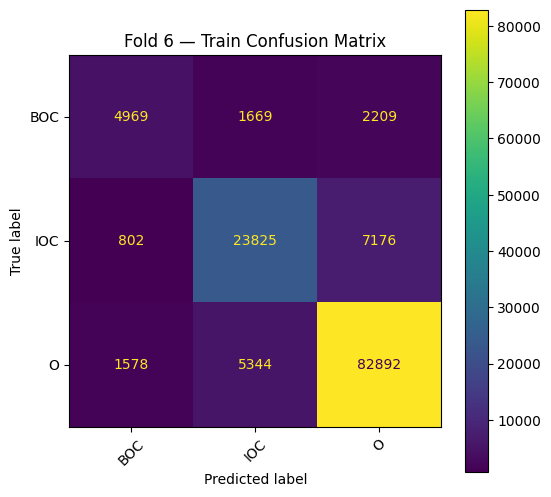

/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: BOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: IOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))



Test classification report:
              precision    recall  f1-score   support

         BOC       0.59      0.49      0.54      1759
         IOC       0.70      0.66      0.68      6487
           O       0.86      0.89      0.88     18226

    accuracy                           0.81     26472
   macro avg       0.72      0.68      0.70     26472
weighted avg       0.80      0.81      0.81     26472



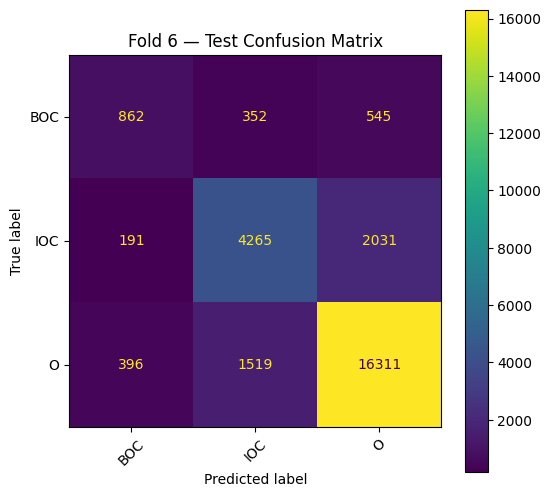

In [ ]:
# CELL 6 — FOLD 6
fold_idx = 6
train_idx, test_idx = splits[5]

train_data = hf_ds.select(train_idx)
test_data  = hf_ds.select(test_idx)

tokenized_train = train_data.map(tokenize_and_align_labels, batched=True, remove_columns=train_data.column_names)
tokenized_test  = test_data.map(tokenize_and_align_labels, batched=True, remove_columns=test_data.column_names)

model = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

training_args = TrainingArguments(
    output_dir=f"./fold{fold_idx}",
    evaluation_strategy="epoch",
    save_strategy="no",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION,
    learning_rate=LEARNING_RATE,
    num_train_epochs=EPOCHS,
    weight_decay=WEIGHT_DECAY,
    warmup_steps=WARMUP_STEPS,
    fp16=FP16 and torch.cuda.is_available(),
    logging_strategy="epoch",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    compute_metrics=compute_metrics
)

print(f"🚀 Training Fold {fold_idx} (epochs={EPOCHS}) ...")
trainer.train()

print(f"\n📊 Trainer Evaluate (Fold {fold_idx})")
eval_metrics = trainer.evaluate(eval_dataset=tokenized_test)
train_metrics = trainer.evaluate(eval_dataset=tokenized_train)

print("\n--- TRAIN METRICS (from trainer.evaluate) ---")
print(train_metrics)
print("\n--- TEST METRICS (from trainer.evaluate) ---")
print(eval_metrics)

# Confusion matrices
def preds_and_labels(tok_dataset):
    preds_output = trainer.predict(tok_dataset)
    preds = np.argmax(preds_output.predictions, axis=2)
    labels = preds_output.label_ids

    y_true = []
    y_pred = []
    for pred_seq, label_seq in zip(preds, labels):
        for p, l in zip(pred_seq, label_seq):
            if l != -100:
                y_true.append(id2label[int(l)])
                y_pred.append(id2label[int(p)])
    return y_true, y_pred

y_true_train, y_pred_train = preds_and_labels(tokenized_train)
cm_labels = label_list
print("\nTrain classification report:")
print(classification_report(y_true_train, y_pred_train, labels=cm_labels, zero_division=0))
fig = plt.figure(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true_train, y_pred_train, labels=cm_labels), display_labels=cm_labels)
disp.plot(ax=plt.gca(), xticks_rotation=45)
plt.title(f"Fold {fold_idx} — Train Confusion Matrix")
plt.show()

y_true_test, y_pred_test = preds_and_labels(tokenized_test)
print("\nTest classification report:")
print(classification_report(y_true_test, y_pred_test, labels=cm_labels, zero_division=0))
fig = plt.figure(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true_test, y_pred_test, labels=cm_labels), display_labels=cm_labels)
disp.plot(ax=plt.gca(), xticks_rotation=45)
plt.title(f"Fold {fold_idx} — Test Confusion Matrix")
plt.show()


Cleaned dataset size: 6415
Train size: 5132 | Test size: 1283


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Map:   0%|          | 0/5132 [00:00<?, ? examples/s]

Map:   0%|          | 0/1283 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1692068724.py:101: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.048463,0.989867,0.989836,0.989867,0.989843
2,0.107500,0.027730,0.994544,0.994588,0.994544,0.994557
3,0.107500,0.026042,0.995323,0.995384,0.995323,0.995338
4,0.033600,0.014172,0.997662,0.997667,0.997662,0.997664
5,0.015000,0.008351,0.998441,0.998441,0.998441,0.998441



FINAL METRICS: {'eval_loss': 0.008350837975740433, 'eval_accuracy': 0.9984411535463756, 'eval_precision': 0.9984411535463756, 'eval_recall': 0.9984411535463756, 'eval_f1': 0.9984411535463756, 'eval_runtime': 8.8385, 'eval_samples_per_second': 145.16, 'eval_steps_per_second': 9.164, 'epoch': 5.0}

Generating Confusion Matrix...

Confusion Matrix:
[[ 239    1]
 [   1 1042]]


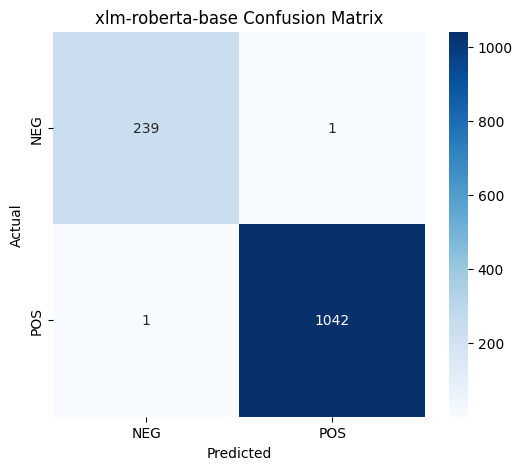

In [ ]:
import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------
# LOAD DATA
# -----------------------
df = pd.read_csv("/content/TV_Reviews_Cause_Sentiment(TV_Reviews_Cause_Sentiment).csv", encoding="latin1")

df = df[["Causal Phrase", "Sentiment"]].copy()
df["Sentiment"] = df["Sentiment"].astype(str).str.strip()
df = df[df["Sentiment"] != ""]

label2id = {"NEGATIVE": 0, "POSITIVE": 1}
id2label = {0: "NEGATIVE", 1: "POSITIVE"}

df = df[df["Sentiment"].isin(label2id.keys())]
df["label"] = df["Sentiment"].map(label2id)
df = df.dropna()

print("Cleaned dataset size:", len(df))

# -----------------------
# TRAIN/TEST SPLIT
# -----------------------
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)

print(f"Train size: {len(train_df)} | Test size: {len(test_df)}")

train_ds = Dataset.from_pandas(train_df[["Causal Phrase", "label"]])
test_ds  = Dataset.from_pandas(test_df[["Causal Phrase", "label"]])

# -----------------------
# TOKENIZER
MODEL_NAME = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize(batch):
    return tokenizer(batch["Causal Phrase"], truncation=True, padding="max_length", max_length=128)

train_ds = train_ds.map(tokenize, batched=True)
test_ds  = test_ds.map(tokenize, batched=True)

train_ds = train_ds.rename_column("label", "labels")
test_ds = test_ds.rename_column("label", "labels")

train_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# -----------------------
# MODEL
# -----------------------
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)

# -----------------------
# METRICS
# -----------------------
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    acc = accuracy_score(labels, preds)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    return {"accuracy": acc, "precision": p, "recall": r, "f1": f1}

# -----------------------
# TRAINER
# -----------------------
training_args = TrainingArguments(
    output_dir="./sentiment_bert",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics
)

# -----------------------
# TRAIN
# -----------------------
trainer.train()

# -----------------------
# FINAL EVALUATION
# -----------------------
metrics = trainer.evaluate(test_ds)
print("\nFINAL METRICS:", metrics)

# -----------------------
# CONFUSION MATRIX
# -----------------------
print("\nGenerating Confusion Matrix...")
pred_output = trainer.predict(test_ds)

preds = np.argmax(pred_output.predictions, axis=1)
true_labels = pred_output.label_ids

cm = confusion_matrix(true_labels, preds)
print("\nConfusion Matrix:")
print(cm)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=["NEG", "POS"],
            yticklabels=["NEG", "POS"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("xlm-roberta-base Confusion Matrix")
plt.show()
